In [60]:
#Library 
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_squared_error, r2_score
import optuna
from sklearn.datasets import make_regression
from tqdm import tqdm
import math
import shap
import matplotlib.pyplot as plt
import lime
import lime.lime_tabular

In [61]:
df = pd.read_csv('/Users/victorabsil/Desktop/EssecxCentrale/Hackathon_Eleven/final_data/merged_datasets_with_events.csv',sep =',')

# Deleting the covid period
covid_start = '2020-03-01'
covid_stop = '2022-01-01'
df = df[(df['WORK_DATE'] < covid_start) | (df['WORK_DATE'] > covid_stop)]

df.head()


,WORK_DATE,DEB_TIME,DEB_TIME_HOUR,FIN_TIME,ENTITY_DESCRIPTION_SHORT,WAIT_TIME_MAX,NB_UNITS,GUEST_CARRIED,CAPACITY,ADJUST_CAPACITY,...,humidity,wind_speed,rain_1h,rain_3h,snow_1h,weather_description,REF_CLOSING_DESCRIPTION,ATTENDANCE,NIGHT_SHOW_FLAG,PARADE_FLAG
0,2018-06-01,2018-06-01 19:00:00,19,2018-06-01 19:15:00.000,Roller Coaster,15,2.0,50.0,75.00,75.00,...,89,1.59,0.22,0.0,0.0,light rain,Open,46804.0,0,0
1,2018-06-01,2018-06-01 20:30:00,20,2018-06-01 20:45:00.000,Zipline,40,12.0,69.0,101.25,101.25,...,93,1.67,0.20,0.0,0.0,light rain,Open,46804.0,0,0
2,2018-06-01,2018-06-01 16:30:00,16,2018-06-01 16:45:00.000,Spinning Coaster,15,5.0,283.0,526.25,438.50,...,87,2.94,0.23,0.0,0.0,light rain,Open,46804.0,0,0
3,2018-06-01,2018-06-01 20:30:00,20,2018-06-01 20:45:00.000,Giant Wheel,30,4.0,0.0,503.75,0.00,...,93,1.67,0.20,0.0,0.0,light rain,Open,46804.0,0,0
4,2018-06-01,2018-06-01 13:45:00,13,2018-06-01 14:00:00.000,Oz Theatre,0,0.0,0.0,0.00,0.00,...,77,1.92,0.31,0.0,0.0,light rain,Fermeture Opérationnelle,46804.0,0,0


In [62]:
# Encoding

#Time management 
df['WORK_DATE'] = pd.to_datetime(df['WORK_DATE'])
df['DEB_TIME'] = pd.to_datetime(df['DEB_TIME'])

df['month'] = df['WORK_DATE'].dt.month
df['day'] = df['WORK_DATE'].dt.day
df['weekday'] = df['WORK_DATE'].dt.dayofweek
df.drop(columns=['WORK_DATE'])

df['hour'] = df['DEB_TIME'].dt.hour
df['minute'] = df['DEB_TIME'].dt.minute
df.drop(columns=['DEB_TIME'])
df.drop(columns=['FIN_TIME'])

#Cyclic function to capture the cyclique evolution of the day 

def encode_cyclic_feature(df, col, max_val):
    df[f'{col}_sin'] = np.sin(2 * np.pi * df[col] / max_val)
    df[f'{col}_cos'] = np.cos(2 * np.pi * df[col] / max_val)
    df = df.drop(columns=[col])  # Delete the original column 
    return df


df = encode_cyclic_feature(df, 'month', 12) 
df = encode_cyclic_feature(df, 'day', 31)  
df = encode_cyclic_feature(df, 'weekday', 7)  
df = encode_cyclic_feature(df, 'hour', 24)  
df = encode_cyclic_feature(df, 'minute', 60) 

In [63]:
numerical_features = df.select_dtypes(include=['float64']).columns.tolist()
print("Variables numériques :", numerical_features)

Variables numériques : ['NB_UNITS', 'GUEST_CARRIED', 'CAPACITY', 'ADJUST_CAPACITY', 'NB_MAX_UNIT', 'temp', 'feels_like', 'wind_speed', 'rain_1h', 'rain_3h', 'snow_1h', 'ATTENDANCE', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'weekday_sin', 'weekday_cos', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos']


In [64]:
#ATTENTIO J'AI DROP L'ATTENDANCE

'''
Colonnes garder : 
feels_like
wind_speed
weather
REF_CLOSING_DESCRIPTION
NIGHT_SHOW_FLAG
PARADE_FLAG
weather_description

'''

df = df.drop(columns=['DEB_TIME_HOUR', 'NB_UNITS', 'GUEST_CARRIED', 'NB_MAX_UNIT', 'temp', 'humidity', 'DEB_TIME', 'WORK_DATE', 
                      'FIN_TIME', 'wind_speed', 'rain_1h', 'rain_3h', 'snow_1h','DOWNTIME'])


#Attention j'ai supprimé les données de pluie 
df.columns

Index(['ENTITY_DESCRIPTION_SHORT', 'WAIT_TIME_MAX', 'CAPACITY',
       'ADJUST_CAPACITY', 'OPEN_TIME', 'UP_TIME', 'feels_like',
       'weather_description', 'REF_CLOSING_DESCRIPTION', 'ATTENDANCE',
       'NIGHT_SHOW_FLAG', 'PARADE_FLAG', 'month_sin', 'month_cos', 'day_sin',
       'day_cos', 'weekday_sin', 'weekday_cos', 'hour_sin', 'hour_cos',
       'minute_sin', 'minute_cos'],
      dtype='object')

In [65]:
weather_mapping = {'sky is clear' : 10 ,'few clouds' : 9 , 'scattered clouds' : 8 , 'broken clouds' : 7, 'overcast clouds' : 6, 'light snow' : 5, 'light rain' : 4, 'snow' : 3, 'moderate rain' : 2, 'heavy intensity rain' : 1}

df['weather_description'] = df['weather_description'].map(weather_mapping)

In [67]:
df['REF_CLOSING_DESCRIPTION'] = df['REF_CLOSING_DESCRIPTION'].isin(['Open', 'Fermeture Opérationnelle'])
closing_mapping = {'Open' : 1, 'Fermeture Opérationnelle' : 0}

df['REF_CLOSING_DESCRIPTION'] = df['REF_CLOSING_DESCRIPTION'].map(closing_mapping)

In [68]:
categorical_cols = ['ENTITY_DESCRIPTION_SHORT']

df = pd.get_dummies(df, columns=categorical_cols, drop_first=True, dtype=int)

In [69]:
columnslist = []
for columns in df:
    print(f'Columns name :', columns, " & type :", df[columns].dtypes)
    if columns != 'WAIT_TIME_MAX':
        columnslist.append(columns)

print(columnslist)


Columns name : WAIT_TIME_MAX  & type : int64
Columns name : CAPACITY  & type : float64
Columns name : ADJUST_CAPACITY  & type : float64
Columns name : OPEN_TIME  & type : int64
Columns name : UP_TIME  & type : int64
Columns name : feels_like  & type : float64
Columns name : weather_description  & type : int64
Columns name : REF_CLOSING_DESCRIPTION  & type : float64
Columns name : ATTENDANCE  & type : float64
Columns name : NIGHT_SHOW_FLAG  & type : int64
Columns name : PARADE_FLAG  & type : int64
Columns name : month_sin  & type : float64
Columns name : month_cos  & type : float64
Columns name : day_sin  & type : float64
Columns name : day_cos  & type : float64
Columns name : weekday_sin  & type : float64
Columns name : weekday_cos  & type : float64
Columns name : hour_sin  & type : float64
Columns name : hour_cos  & type : float64
Columns name : minute_sin  & type : float64
Columns name : minute_cos  & type : float64
Columns name : ENTITY_DESCRIPTION_SHORT_Bungee Jump  & type : int64


In [70]:
df.columns

Index(['WAIT_TIME_MAX', 'CAPACITY', 'ADJUST_CAPACITY', 'OPEN_TIME', 'UP_TIME',
       'feels_like', 'weather_description', 'REF_CLOSING_DESCRIPTION',
       'ATTENDANCE', 'NIGHT_SHOW_FLAG', 'PARADE_FLAG', 'month_sin',
       'month_cos', 'day_sin', 'day_cos', 'weekday_sin', 'weekday_cos',
       'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos',
       'ENTITY_DESCRIPTION_SHORT_Bungee Jump',
       'ENTITY_DESCRIPTION_SHORT_Circus Train',
       'ENTITY_DESCRIPTION_SHORT_Crazy Dance',
       'ENTITY_DESCRIPTION_SHORT_Dizzy Dropper',
       'ENTITY_DESCRIPTION_SHORT_Drop Tower',
       'ENTITY_DESCRIPTION_SHORT_Flying Coaster',
       'ENTITY_DESCRIPTION_SHORT_Free Fall',
       'ENTITY_DESCRIPTION_SHORT_Giant Wheel',
       'ENTITY_DESCRIPTION_SHORT_Giga Coaster',
       'ENTITY_DESCRIPTION_SHORT_Go-Karts',
       'ENTITY_DESCRIPTION_SHORT_Haunted House',
       'ENTITY_DESCRIPTION_SHORT_Himalaya Ride',
       'ENTITY_DESCRIPTION_SHORT_Inverted Coaster',
       'ENTITY_DESCRIPTION_SHO

In [71]:
#Train test split 
np.random.seed(42)
df_fin = df[['ATTENDANCE', 'ADJUST_CAPACITY', 'feels_like', 'weather_description',
        'REF_CLOSING_DESCRIPTION', 'NIGHT_SHOW_FLAG', 'PARADE_FLAG',
        'month_sin', 'month_cos', 'day_sin', 'day_cos', 'weekday_sin', 
        'weekday_cos', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'ENTITY_DESCRIPTION_SHORT_Bungee Jump',
       'ENTITY_DESCRIPTION_SHORT_Circus Train',
       'ENTITY_DESCRIPTION_SHORT_Crazy Dance',
       'ENTITY_DESCRIPTION_SHORT_Dizzy Dropper',
       'ENTITY_DESCRIPTION_SHORT_Drop Tower',
       'ENTITY_DESCRIPTION_SHORT_Flying Coaster',
       'ENTITY_DESCRIPTION_SHORT_Free Fall',
       'ENTITY_DESCRIPTION_SHORT_Giant Wheel',
       'ENTITY_DESCRIPTION_SHORT_Giga Coaster',
       'ENTITY_DESCRIPTION_SHORT_Go-Karts',
       'ENTITY_DESCRIPTION_SHORT_Haunted House',
       'ENTITY_DESCRIPTION_SHORT_Himalaya Ride',
       'ENTITY_DESCRIPTION_SHORT_Inverted Coaster',
       'ENTITY_DESCRIPTION_SHORT_Kiddie Coaster',
       'ENTITY_DESCRIPTION_SHORT_Merry Go Round',
       'ENTITY_DESCRIPTION_SHORT_Oz Theatre',
       'ENTITY_DESCRIPTION_SHORT_Rapids Ride',
       'ENTITY_DESCRIPTION_SHORT_Roller Coaster',
       'ENTITY_DESCRIPTION_SHORT_Spinning Coaster',
       'ENTITY_DESCRIPTION_SHORT_Spiral Slide',
       'ENTITY_DESCRIPTION_SHORT_Superman Ride',
       'ENTITY_DESCRIPTION_SHORT_Swing Ride',
       'ENTITY_DESCRIPTION_SHORT_Vertical Drop',
       'ENTITY_DESCRIPTION_SHORT_Water Ride',
       'ENTITY_DESCRIPTION_SHORT_Zipline']]

y = df['WAIT_TIME_MAX']
X_train, X_test, y_train, y_test = train_test_split(df_fin, y,test_size=0.2, random_state=42)

In [72]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 7, 12],
    'subsample': [0.4, 0.8],
    'gamma': [0,2, 3],
    'random_state': [42]
}


In [73]:
def objective(trial):
    # Création des paramètres à partir de la grille
    params = {key: trial.suggest_categorical(key, values) for key, values in param_grid.items()}
    
    # Entraînement du modèle XGBoost en mode régression
    model = xgb.XGBRegressor(**params, objective='reg:squarederror')
    model.fit(X_train, y_train)
    
    # Prédictions sur l'ensemble de test
    y_pred = model.predict(X_test)
    
    # Calcul du MAE (on optimise le MAE)
    mae = mean_absolute_error(y_test, y_pred)
    return mae

# Calcul du nombre total d'essais (produit des tailles des listes de la grille)
total_trials = math.prod([len(values) for values in param_grid.values()])

# Création de la barre de progression tqdm
pbar = tqdm(total=total_trials, desc="Grid Search Trials", unit="trial")

# Callback simple : incrémente la barre de 1 à chaque essai terminé
def progress_callback(study, trial):
    pbar.update(1)

# Initialisation du GridSampler avec la grille définie
sampler = optuna.samplers.GridSampler(param_grid)

# Création de l'étude (on minimise le MAE)
study = optuna.create_study(sampler=sampler, direction="minimize")

# Lancement de l'optimisation en passant le callback pour mettre à jour tqdm
study.optimize(objective, callbacks=[progress_callback])
pbar.close()

# Affichage final (résumé)
print("Meilleurs paramètres :", study.best_params)
print("Meilleur MAE :", study.best_value)

Grid Search Trials:   0%|          | 0/162 [00:00<?, ?trial/s][I 2025-02-12 17:14:14,189] A new study created in memory with name: no-name-cd5bde2a-a1e1-401e-8889-3454ee229f06
[I 2025-02-12 17:14:21,514] Trial 0 finished with value: 9.425077970810243 and parameters: {'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': 12, 'subsample': 0.4, 'gamma': 2, 'random_state': 42}. Best is trial 0 with value: 9.425077970810243.
Grid Search Trials: 100%|██████████| 162/162 [29:36<00:00, 10.97s/trial]

Meilleurs paramètres : {'n_estimators': 300, 'learning_rate': 0.2, 'max_depth': 12, 'subsample': 0.8, 'gamma': 2, 'random_state': 42}
Meilleur MAE : 3.3704994526948178


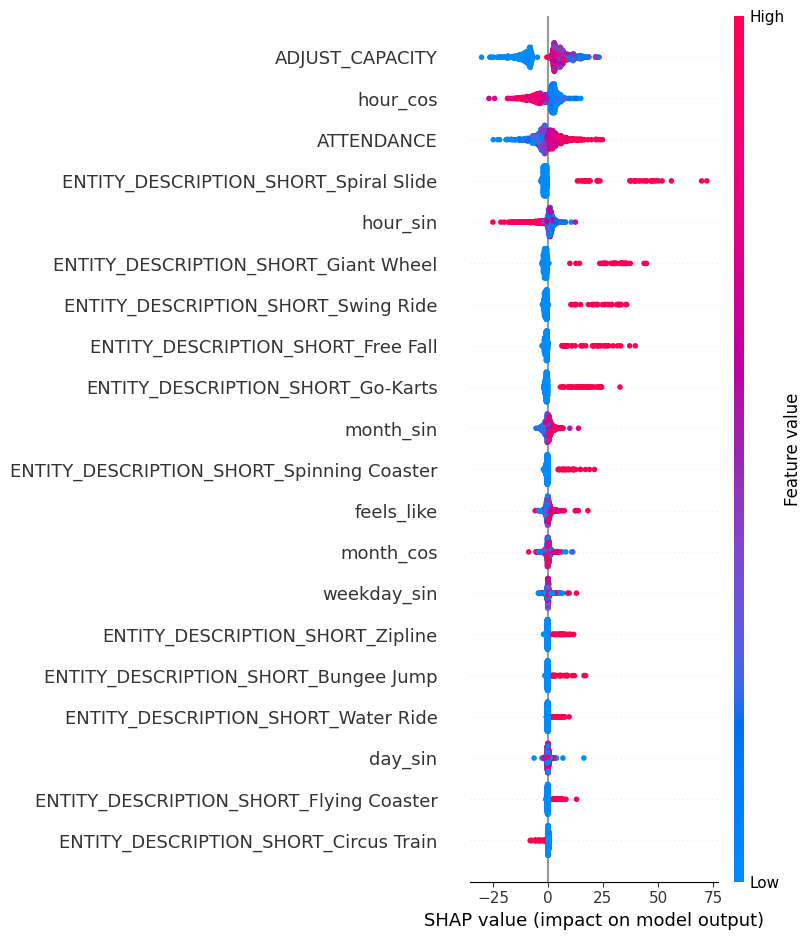

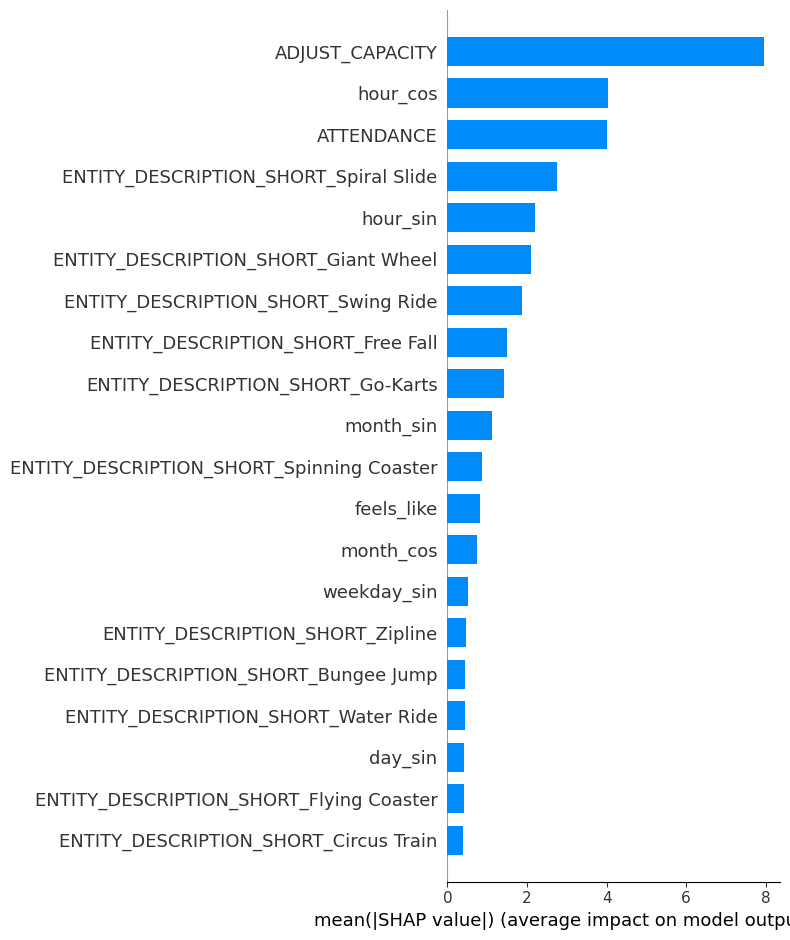

In [74]:
# -------------------------------
# Analyse SHAP sur le meilleur modèle
# -------------------------------

# 1. Entraînement du meilleur modèle sur l'ensemble d'entraînement
best_model = xgb.XGBRegressor(**study.best_params, objective='reg:squarederror')
best_model.fit(X_train, y_train)

# 2. Création d'un explainer SHAP pour les modèles basés sur des arbres
explainer = shap.TreeExplainer(best_model)

X_sample = X_train.sample(n=1000, random_state=42)

# 3. Calcul des valeurs SHAP sur l'ensemble d'entraînement
shap_values = explainer.shap_values(X_sample)

# 4. Visualisation de l'importance des features via un summary plot
shap.summary_plot(shap_values, X_sample)

# Vous pouvez également afficher un summary plot de type "bar" pour une vue plus synthétique
shap.summary_plot(shap_values, X_sample, plot_type="bar")

Features dont l'impact est quasiment nul (mean abs SHAP < 0.01):
                                   feature  mean_abs_shap
4                  REF_CLOSING_DESCRIPTION       0.000000
39  ENTITY_DESCRIPTION_SHORT_Vertical Drop       0.006586


<Figure size 1000x600 with 0 Axes>

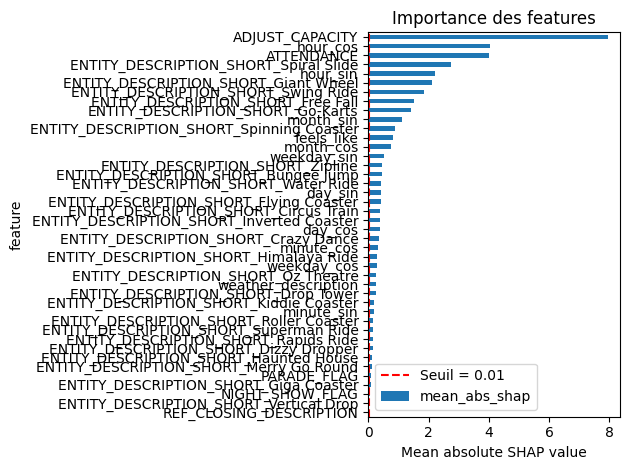

In [75]:
# Calcul de la moyenne des valeurs absolues SHAP pour chaque feature
mean_abs_shap = np.mean(np.abs(shap_values), axis=0)

# Création d'un DataFrame récapitulatif avec le nom de chaque feature et sa moyenne des valeurs absolues SHAP
df_feature_shap = pd.DataFrame({
    'feature': X_sample.columns,
    'mean_abs_shap': mean_abs_shap
})

# Définition d'un seuil : ici, on considère qu'une feature a un impact quasi nul si sa valeur moyenne absolue est inférieure à 0.01
threshold = 0.01

# Filtrer les features dont l'impact est inférieur au seuil
low_impact_features = df_feature_shap[df_feature_shap['mean_abs_shap'] < threshold]

print("Features dont l'impact est quasiment nul (mean abs SHAP < {}):".format(threshold))
print(low_impact_features)

# Optionnel : affichage d'un plot bar pour visualiser toutes les features avec leur impact
plt.figure(figsize=(10,6))
df_feature_shap.sort_values(by='mean_abs_shap', ascending=True).plot.barh(x='feature', y='mean_abs_shap', legend=False)
plt.axvline(threshold, color='red', linestyle='--', label=f'Seuil = {threshold}')
plt.xlabel("Mean absolute SHAP value")
plt.title("Importance des features")
plt.legend()
plt.tight_layout()
plt.show()

Performance du best_model sur le jeu de test :
MAE   : 3.3704994526948178
MSE   : 42.97398113379535
RMSE  : 6.55545430414974
R²    : 0.9184735417366028


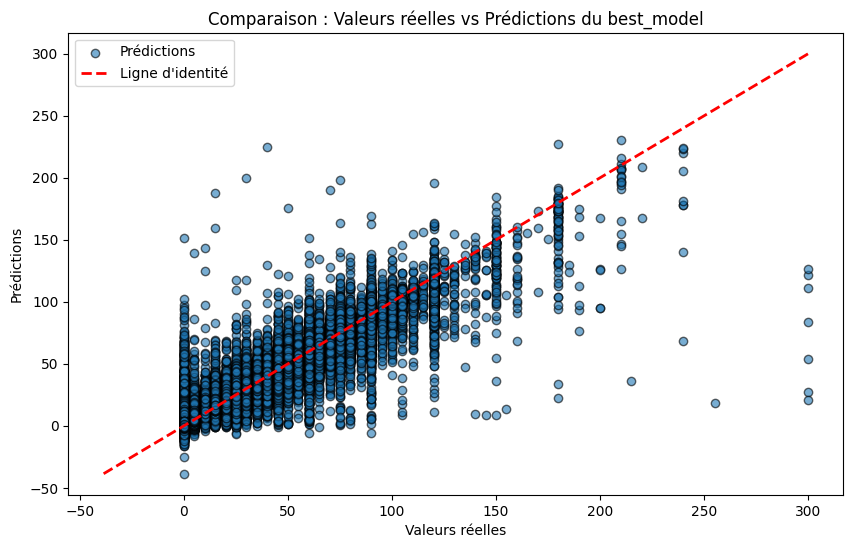

In [76]:
# 1. Appliquer le best_model sur le jeu de test
y_pred = best_model.predict(X_test)

# 2. Calculer les métriques d'évaluation
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Performance du best_model sur le jeu de test :")
print("MAE   :", mae)
print("MSE   :", mse)
print("RMSE  :", rmse)
print("R²    :", r2)

# 3. Comparer graphiquement les valeurs réelles et les prédictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolor='k', label="Prédictions")
plt.xlabel("Valeurs réelles")
plt.ylabel("Prédictions")
plt.title("Comparaison : Valeurs réelles vs Prédictions du best_model")

# Tracer la ligne d'identité (où y = x)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label="Ligne d'identité")

plt.legend()
plt.show()